### Basic Process Discovery (BPI Challenge 2019)

### Example 1:

=== Example 01 (OCEL): Load + basic stats + flatten + discovery ===
OCEL path: BPIC19.jsonocel

[1/5] Loading OCEL ...
OCEL loaded successfully.

--- OCEL basic stats ---
Number of events: 1595923
Number of objects: 330685
Event attributes: ['ocel:eid', 'ocel:timestamp', 'ocel:activity', 'ID', 'cCompany', 'cDocType', 'cGR', 'cGRbasedInvVerif', 'cID', 'cItem', 'cItemCat', 'cItemType', 'cPOID', 'cPurDocCat', 'cSpendAreaText', 'cSpendClassText', 'cSubSPendAreaText', 'cVendor', 'cVendorName', 'eCumNetWorth', 'idx', 'resource']
Object attributes: ['ocel:oid', 'ocel:type']

Most common object type detected: POItem

[2/5] Flattening OCEL -> classic event log ...
Flattening completed.
Number of cases (classic): 1595923

[3/5] Using sample log: 2000 cases (faster run)
Cases used for discovery: 2000
Events used for discovery: 229

[4/5] Discovering Petri net with Inductive Miner ...
Discovery completed.

[5/5] Visualization + saving figures ...
Graphviz detected (dot). Creating Petri net figure.

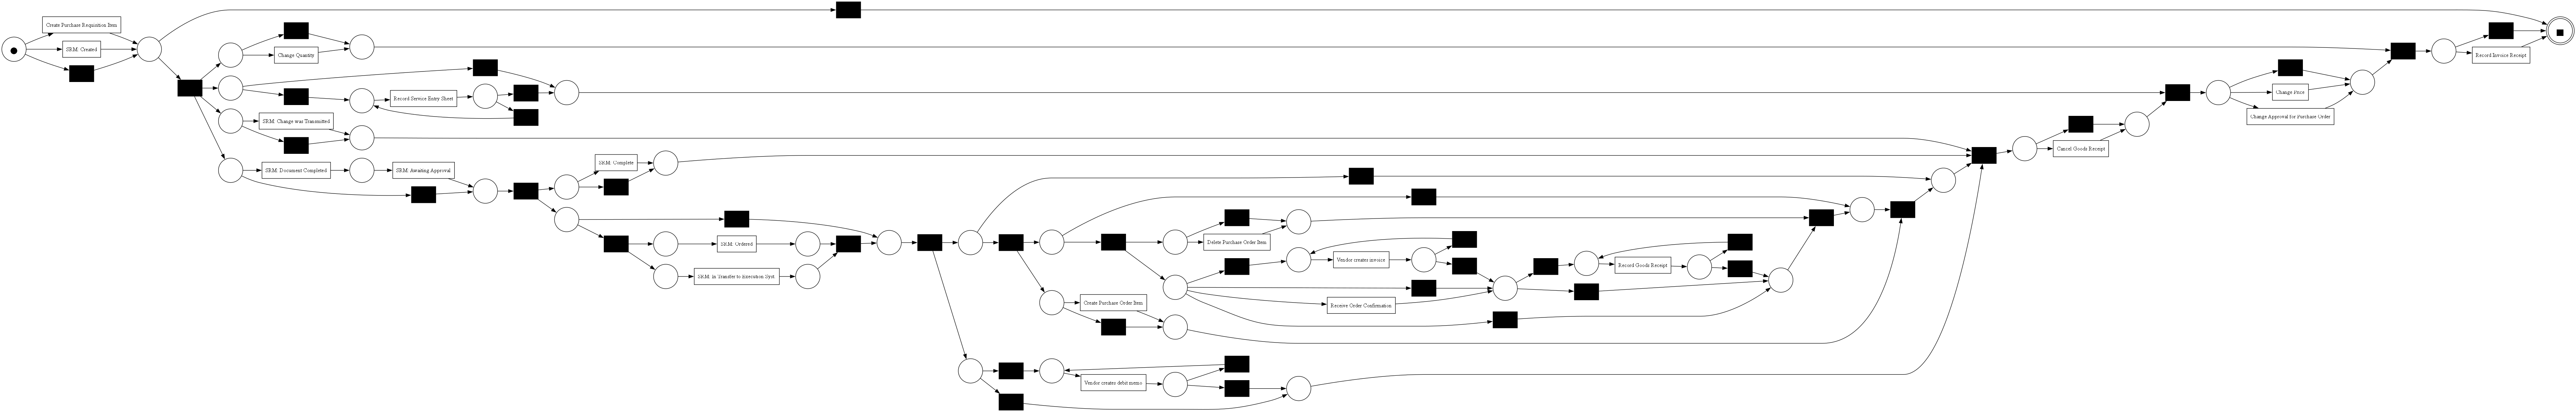


DONE. Example 01 finished successfully.


In [1]:
import os
import shutil
import warnings

import pm4py


# =========================
# CONFIGURATION
# =========================
OCEL_PATH = r"BPIC19.jsonocel"

# Speed-up for big dataset
USE_SAMPLE = True
SAMPLE_CASES = 2000  # try 500 / 1000 / 2000

# Output figures (for thesis)
OUTPUT_DIR = "outputs"
PETRI_PNG = os.path.join(OUTPUT_DIR, "example01_petri_net.png")
DFG_PNG = os.path.join(OUTPUT_DIR, "example01_dfg.png")
# =========================


def graphviz_dot_available() -> bool:
    """Check if Graphviz 'dot' is available in system PATH."""
    return shutil.which("dot") is not None


def ensure_output_dir():
    os.makedirs(OUTPUT_DIR, exist_ok=True)


def basic_stats(event_log):
    cases = len(event_log)
    events = sum(len(t) for t in event_log)
    return cases, events


def main():
    print("=== Example 01 (OCEL): Load + basic stats + flatten + discovery ===")
    print("OCEL path:", OCEL_PATH)

    # Reduce noisy warnings (does not affect correctness)
    warnings.filterwarnings("ignore")

    if not os.path.exists(OCEL_PATH):
        raise FileNotFoundError(
            f"OCEL file not found: {OCEL_PATH}\n"
            "Place BPIC19.jsonocel in the same folder as this script, or update OCEL_PATH."
        )

    ensure_output_dir()

    # 1) Read OCEL
    print("\n[1/5] Loading OCEL ...")
    ocel = pm4py.read_ocel(OCEL_PATH)
    print("OCEL loaded successfully.")

    # 2) Basic OCEL stats
    events_df = ocel.events
    objects_df = ocel.objects
    obj_type_col = ocel.object_type_column

    print("\n--- OCEL basic stats ---")
    print("Number of events:", len(events_df))
    print("Number of objects:", len(objects_df))
    print("Event attributes:", list(events_df.columns))
    print("Object attributes:", list(objects_df.columns))

    # 3) Choose object type (most common) and flatten to classic log
    most_common_type = objects_df[obj_type_col].value_counts().index[0]
    print("\nMost common object type detected:", most_common_type)

    print("\n[2/5] Flattening OCEL -> classic event log ...")
    classic_log = pm4py.ocel_flattening(ocel, most_common_type)
    print("Flattening completed.")
    print("Number of cases (classic):", len(classic_log))

    # 4) Use sample for faster discovery
    log_to_use = classic_log
    if USE_SAMPLE:
        log_to_use = classic_log[:SAMPLE_CASES]
        print(f"\n[3/5] Using sample log: {len(log_to_use)} cases (faster run)")
    else:
        print("\n[3/5] Using FULL log (may take longer)")

    c_cases, c_events = basic_stats(log_to_use)
    print("Cases used for discovery:", c_cases)
    print("Events used for discovery:", c_events)

    # 5) Discovery (Petri net)
    print("\n[4/5] Discovering Petri net with Inductive Miner ...")
    net, im, fm = pm4py.discover_petri_net_inductive(log_to_use)
    print("Discovery completed.")

    # 6) Visualization + Save figure for thesis
    print("\n[5/5] Visualization + saving figures ...")

    if graphviz_dot_available():
        print("Graphviz detected (dot). Creating Petri net figure...")
        # Save Petri net PNG (great for thesis)
        pm4py.save_vis_petri_net(net, im, fm, PETRI_PNG)
        print("Saved Petri net PNG to:", PETRI_PNG)

        # Also show it
        pm4py.view_petri_net(net, im, fm)

    else:
        print("⚠️ Graphviz 'dot' NOT found. Petri net cannot be rendered on this system.")
        print("Falling back to DFG visualization (does not require Graphviz)...")

        dfg, start_acts, end_acts = pm4py.discover_dfg(log_to_use)

        # Save DFG PNG (still useful for thesis)
        pm4py.save_vis_dfg(dfg, start_acts, end_acts, DFG_PNG)
        print("Saved DFG PNG to:", DFG_PNG)

        # Also show it
        pm4py.view_dfg(dfg, start_acts, end_acts)

    print("\nDONE. Example 01 finished successfully.")


if __name__ == "__main__":
    main()
